In [4]:
import torch
import numpy as np
import cv2
import os 
import pandas as pd
import albumentations as A
#from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from albumentations.pytorch.functional import img_to_tensor
#from tensorboardX import SummaryWriter
from tqdm.notebook import tqdm

ModuleNotFoundError: No module named 'torch'

In [6]:
from helpers5classes.config import load_config
conf = load_config('helpers/effb7_conf.json') 

In [7]:
import segmentation_models_pytorch as smp
#model = smp.Unet(encoder_name='resnet34', classes=5)
#model = model.cuda()

In [8]:
# Mosaic 

In [9]:
def convert_mask(mask):
   
    color_mappings = {
        0: (0, 0, 0),
        1: (0, 255, 255),
        2: (255, 0, 0),
        3: (153, 76, 0),
        4: (0, 153, 0)
    }

   
    height, width= mask.shape
    rgb_mask = np.zeros((height, width, 3), dtype=np.uint8)

   
    for class_idx, color in color_mappings.items():
        class_mask = (mask == class_idx)
        rgb_mask[class_mask] = color

    
    return rgb_mask

In [10]:
class OilSegmentationModel:
    def __init__(self, transforms=None, conf=None, ckpt=None):
        self.conf = load_config(conf)
        self.ckpt = ckpt
        
        model = smp.Unet(encoder_name='efficientnet-b7', classes=2, encoder_weights=None)
        self.normalize = self.conf["input"]["normalize"]
        self.transforms = transforms
        checkpoint = torch.load(self.ckpt, map_location='cpu')
        state_dict = checkpoint['state_dict']
        
        #state_dict = {k[7:]: w for k, w in state_dict.items()}
        model.load_state_dict(state_dict, strict=False)
        model = model.cuda()
        self.model = model.eval()

    def segment_single_image(self, image, mode='path'):
        
        if mode == 'path':
            image = cv2.imread(image)
        
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        
        # Apply augmentations
        sample = self.transforms(image=image)

        sample['image'] = img_to_tensor(np.ascontiguousarray(sample['image']), self.normalize)
        
        with torch.no_grad():
            imgs = torch.unsqueeze(sample["image"], 0).cuda().float()
            output = self.model(imgs)
            #print(output.shape)
            pred = torch.softmax(output, dim=1)
            #print(pred.shape)
            mask = pred.squeeze(0).permute(1,2,0).cpu().numpy().astype(np.float)
            #argmax = torch.argmax(pred, dim=1)
            #print(argmax.shape)
            #mask = argmax.permute(1, 2, 0).cpu().numpy().astype(np.uint8)
            #print(np.unique(mask))

        #mask = size(mask, (image_to_segment.shape[:2]))
        #mask = np.rot90(mask)
        #mask = cv2.resize(mask, (w,h), interpolation=cv2.INTER_NEAREST)
        #print(np.unique(mask))
        #final_mask = np.where(mask==16, 255, mask)
        

        return mask #pred

In [11]:
transform = A.Compose([
        A.Crop(0,0,640,640, p=1.0)
    ])

In [12]:
conf_path = 'helpers/effb7_conf.json'
ckpt_path = 'models/Greece/2 classes/Efficientnet-b7/2/segment_efficientnet-b7_efficientnet-b7_best_miou.pt'

In [13]:
segmenter = OilSegmentationModel(transform, conf_path, ckpt_path)

In [14]:
#img = segmenter.segment_single_image('../../oil_spill_dataset/test/images/42_308,18_108_2.jpg')

In [15]:
#img.shape

In [16]:
#plt.figure(figsize =(500,20))
#plt.imshow(convert_mask(img[:,:,0]))

# MOSAIC

In [17]:
# Masks

0it [00:00, ?it/s]

C:\Users\spark lab\AppData\Local\Temp\ipykernel_1476\1863222535.py:36: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = pred.squeeze(0).permute(1,2,0).cpu().numpy().astype(np.float)


[0 1]
[0 1]
[0 1]
[0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0]
[0 1]


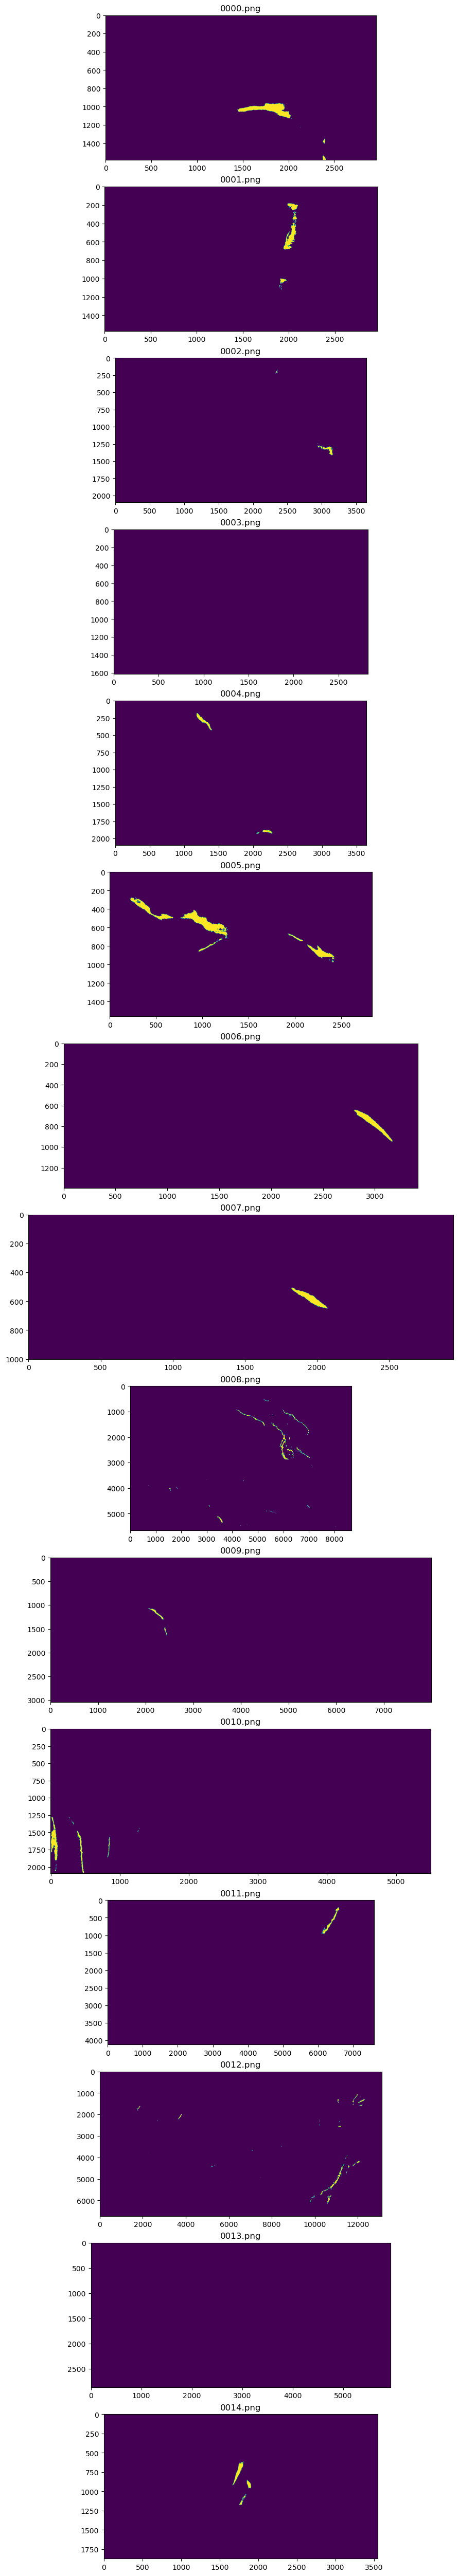

In [18]:
png_files = os.listdir('Preprocessing Folder/png_files')

fig, axs = plt.subplots(len(png_files), 1, figsize = (50, 50), constrained_layout = True) 

for idx, png_name in tqdm(enumerate(png_files)):
    img = cv2.imread(f'Preprocessing Folder/png_files/{png_name}')

    #img = cv2.medianBlur(img, 3)

    # Define the patch size and overlap
    patch_size = (640, 640)
    overlap = 0.5
    #print(img.shape)
    # Load the semantic segmentation model
    segmentation_map = np.zeros((img.shape[0], img.shape[1], 2), dtype=np.float32)
    #print(segmentation_map.shape)
    # Loop over the image patches
    for y in range(0, img.shape[0], int(patch_size[0] * overlap)):
        for x in range(0, img.shape[1], int(patch_size[1] * overlap)):



            patch = img[y:y+patch_size[0], x:x+patch_size[1]]
            #print(patch.shape)
            #print(patch.shape[0])

            if patch.shape[1] < patch_size[1] and patch.shape[0] == patch_size[0]:
                patch = img[y:y+patch_size[0], img.shape[1]-patch_size[1]:img.shape[1]]
                patch_seg_map = segmenter.segment_single_image(patch, 'img')
                segmentation_map[y:y+patch_size[0], img.shape[1]-patch_size[1]:img.shape[1]] += patch_seg_map
                #print(segmentation_map.shape)
            elif patch.shape[0] < patch_size[0] and patch.shape[1] == patch_size[1]:
                patch = img[img.shape[0]-patch_size[0]:img.shape[0], x:x+patch_size[1]]
                patch_seg_map = segmenter.segment_single_image(patch, 'img')
                segmentation_map[img.shape[0]-patch_size[0]:img.shape[0], x:x+patch_size[1]] += patch_seg_map
            elif patch.shape[0] < patch_size[0] and patch.shape[1] < patch_size[1]:
                patch = img[img.shape[0]-patch_size[0]:img.shape[0], img.shape[1]-patch_size[1]:img.shape[1]]
                patch_seg_map = segmenter.segment_single_image(patch, 'img')
                segmentation_map[img.shape[0]-patch_size[0]:img.shape[0], img.shape[1]-patch_size[1]:img.shape[1]] += patch_seg_map
            else:
            #patch = cv2.resize(patch, (256, 256))
            #patch = np.expand_dims(patch, axis=0)

                patch_seg_map = segmenter.segment_single_image(patch, 'img')
            #patch_seg_map = cv2.resize(patch_seg_map, patch_size)
                segmentation_map[y:y+patch_size[0], x:x+patch_size[1]] += patch_seg_map
                
    segmentation_map = np.argmax(segmentation_map, axis=-1)
    print(np.unique(segmentation_map))
    axs[idx].imshow(segmentation_map)
    axs[idx].title.set_text(png_name)
    

In [15]:
#np.unique(mask)
segmentation_map.shape

(1873, 3548)

In [16]:
segmentation_map = np.argmax(segmentation_map, axis=-1)

In [17]:
segmentation_map.shape

(1873,)

TypeError: Invalid shape (1873,) for image data

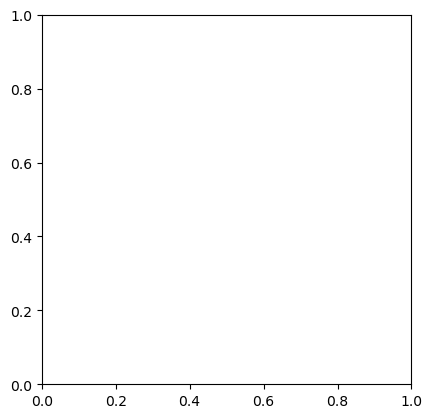

In [18]:
plt.imshow(segmentation_map)

In [ ]:
np.unique(segmentation_map)

In [ ]:
segmentation_map.shape

In [ ]:
plt.figure(figsize =(500,20))
plt.imshow(convert_mask(segmentation_map))

In [ ]:
mask_orig = cv2.imread('../../oil_spill_dataset/test/labels/42_308,18_108_2.png')
mask_orig = cv2.cvtColor(mask_orig, cv2.COLOR_BGR2RGB)

plt.figure(figsize =(500,20))

plt.imshow(mask_orig)